In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="xingjunm/WildDeepfake",
    repo_type="dataset",
    local_dir="./WildDeepfake"
)

<h2>Build Dataset</h2>

<h2>paramaters</h2>

In [2]:
import torch
import numpy as np

DATA_ROOT = "./WildDeepfake"          
DATASET_JSON = "./dataset/dataset.json"  


NUM_FAKE_TRAIN = 150   
NUM_REAL_TRAIN = 150   
NUM_FAKE_TEST = 100    
NUM_REAL_TEST = 100    


MODEL_TYPE = "base"    
PRETRAINED = True      
FREEZE_VIT = False     


NUM_FRAMES = 48       
IMAGE_SIZE = 224       
BATCH_SIZE = 16        
EPOCHS = 10           
LR = 1e-4             
WEIGHT_DECAY = 0.1   
WARMUP_EPOCHS = 3    
NUM_WORKERS = 2     


OUTPUT_DIR = "./checkpoints"

# 设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {DEVICE}")

使用设备: cuda


In [ ]:


from prepare_data import WildDeepfakePreparator


preparator = WildDeepfakePreparator(
    data_root=DATA_ROOT,
    output_root="./dataset"
)


preparator.select_num = {
    "fake_train": NUM_FAKE_TRAIN,
    "real_train": NUM_REAL_TRAIN,
    "fake_test": NUM_FAKE_TEST,
    "real_test": NUM_REAL_TEST,
}


dataset_info = preparator.run()

<h2>check dataset</h2>

In [ ]:
import json
from collections import defaultdict
import random

random.seed(42) 


with open(DATASET_JSON, "r") as f:
    dataset = json.load(f)


test_samples = dataset["test"]
print(len(test_samples))

by_label = defaultdict(list)
for s in test_samples:
    by_label[s["label"]].append(s)


val_samples = []
new_test_samples = []

for label, samples in by_label.items():
    random.shuffle(samples)
    split_idx = len(samples) // 2
    val_samples.extend(samples[:split_idx])
    new_test_samples.extend(samples[split_idx:])


dataset["val"] = val_samples
dataset["test"] = new_test_samples

with open(DATASET_JSON, "w") as f:
    json.dump(dataset, f, indent=2)

print("数据集统计:")
print("=" * 40)
for split in ["train", "val", "test"]:
    samples = dataset[split]
    real_count = sum(1 for s in samples if s["label"] == 0)
    fake_count = sum(1 for s in samples if s["label"] == 1)
    total_frames = sum(s["num_frames"] for s in samples)
    
    print(f"\n{split.upper()}:")
    print(f"  序列数: {len(samples)}")
    print(f"  Real: {real_count}, Fake: {fake_count}")
    print(f"  总帧数: {total_frames}")
    print(f"  平均帧数: {total_frames / len(samples):.1f}")


In [ ]:

import matplotlib.pyplot as plt

train_frames = [s["num_frames"] for s in dataset["train"]]

plt.figure(figsize=(10, 4))
plt.hist(train_frames, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Frames")
plt.ylabel("Count")
plt.title("Frame Distribution in Training Set")
plt.axvline(x=NUM_FRAMES, color='r', linestyle='--', label=f'Sampling: {NUM_FRAMES} frames')
plt.legend()
plt.show()

print(f"帧数 < {NUM_FRAMES} 的序列: {sum(1 for f in train_frames if f < NUM_FRAMES)}")

<h2>DataLoader</h2>

In [3]:
from deepfake_dataset import create_dataloaders, DeepfakeDataset


train_loader, test_loader, val_loader = create_dataloaders(
    json_path=DATASET_JSON,
    batch_size=32,
    num_frames=24,
    image_size=IMAGE_SIZE,
    num_workers=NUM_WORKERS,
    sampling="consecutive",
)

print(f"\n训练集 batches: {len(train_loader)}")
print(f"测试集 batches: {len(test_loader)}")
print(f"val batches: {len(val_loader)}")

[train] 加载 2265 个序列 (过滤掉帧数<8的)
[test] 加载 381 个序列 (过滤掉帧数<8的)
[val] 加载 381 个序列 (过滤掉帧数<8的)

训练集 batches: 70
测试集 batches: 12
val batches: 12


In [4]:

videos, labels = next(iter(train_loader))
print(f"Videos shape: {videos.shape}")  # (B, T, C, H, W)
print(f"Labels: {labels}")

Videos shape: torch.Size([32, 24, 3, 224, 224])
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1])


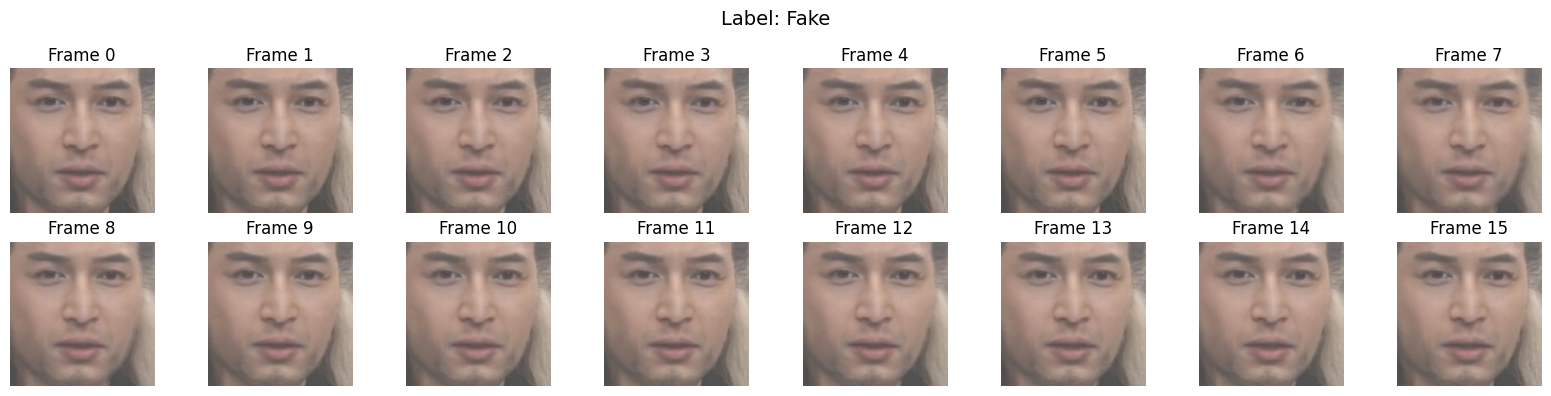

In [5]:

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(tensor):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean


sample_video = videos[0]  # (T, C, H, W)
sample_label = labels[0].item()


fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < len(sample_video):
        img = denormalize(sample_video[i]).permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"Frame {i}")
    ax.axis("off")

plt.suptitle(f"Label: {'Fake' if sample_label == 1 else 'Real'}", fontsize=14)
plt.tight_layout()
plt.show()

<h2>Model</h2>

In [12]:
from model import create_model


model = create_model(
    model_type="lite",
    pretrained=PRETRAINED,
    freeze_vit=True,
    num_classes=2,
    temporal_dropout = 0.1,
    dropout = 0.1,
    use_freq=False,
    temporal_num_heads = 4,
    temporal_num_layers = 4,
)

model = model.to(DEVICE)


创建模型: lite
  ViT: vit_small_patch16_224
  Temporal layers: 4
  使用频域分析: True
ViT 参数已冻结

模型参数统计:
  总参数量: 41.74M
  可训练参数: 20.07M
  ViT 特征维度: 384
  使用频域分析: True
  Temporal 输入维度: 640


In [13]:

with torch.no_grad():
    test_input = videos[:2].to(DEVICE)
    test_output = model(test_input)
    print(f"输入: {test_input.shape}")
    print(f"输出: {test_output.shape}")
    print(f"预测: {test_output.argmax(dim=1)}")

输入: torch.Size([2, 24, 3, 224, 224])
输出: torch.Size([2, 2])
预测: tensor([0, 1], device='cuda:0')


<h2>Train</h2>

In [14]:
from train import Trainer


trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=DEVICE,
    output_dir=OUTPUT_DIR,
    lr=3e-5,
    weight_decay=0.1,
    epochs=20,
    warmup_epochs=5,
    use_amp=True,
    # Focal Loss 设置
    loss_type="focal",     
    focal_gamma=2.0,       
    class_weights="balanced",
)


类别分布: Real=1349, Fake=916
类别权重: Real=0.840, Fake=1.236
Loss 类型: focal
Focal Loss gamma=2.0


In [15]:

history = trainer.train()

开始训练
设备: cuda
训练集大小: 2265
测试集大小: 381
Batch size: 32
Epochs: 20
混合精度: True
输出目录: checkpoints


Epoch 1 [Test]: 100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


  Real 准确率: 50.00%
  Fake 准确率: 65.03%
  Balanced Acc: 57.51%
  保存最佳模型: checkpoints/best.pth

Epoch 1/20 完成 (317.6s)
  Train Loss: 0.1760, Train Acc: 53.71%
  Test Loss: 0.1719, Test Acc: 57.22%
  Balanced Acc: 57.51% (Best: 57.51%)
------------------------------------------------------------


Epoch 2 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


  Real 准确率: 86.87%
  Fake 准确率: 32.24%
  Balanced Acc: 59.55%
  保存最佳模型: checkpoints/best.pth

Epoch 2/20 完成 (318.4s)
  Train Loss: 0.1651, Train Acc: 60.49%
  Test Loss: 0.1763, Test Acc: 60.63%
  Balanced Acc: 59.55% (Best: 59.55%)
------------------------------------------------------------


Epoch 3 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.34s/it]


  Real 准确率: 53.54%
  Fake 准确率: 70.49%
  Balanced Acc: 62.01%
  保存最佳模型: checkpoints/best.pth

Epoch 3/20 完成 (318.1s)
  Train Loss: 0.1502, Train Acc: 67.72%
  Test Loss: 0.1675, Test Acc: 61.68%
  Balanced Acc: 62.01% (Best: 62.01%)
------------------------------------------------------------


Epoch 4 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]


  Real 准确率: 50.51%
  Fake 准确率: 77.05%
  Balanced Acc: 63.78%
  保存最佳模型: checkpoints/best.pth

Epoch 4/20 完成 (316.7s)
  Train Loss: 0.1446, Train Acc: 71.16%
  Test Loss: 0.1698, Test Acc: 63.25%
  Balanced Acc: 63.78% (Best: 63.78%)
------------------------------------------------------------


Epoch 5 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.33s/it]


  Real 准确率: 77.78%
  Fake 准确率: 43.72%
  Balanced Acc: 60.75%

Epoch 5/20 完成 (325.0s)
  Train Loss: 0.1291, Train Acc: 74.78%
  Test Loss: 0.2047, Test Acc: 61.42%
  Balanced Acc: 60.75% (Best: 63.78%)
------------------------------------------------------------


Epoch 6 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]


  Real 准确率: 44.44%
  Fake 准确率: 78.69%
  Balanced Acc: 61.57%

Epoch 6/20 完成 (313.4s)
  Train Loss: 0.1151, Train Acc: 79.60%
  Test Loss: 0.2055, Test Acc: 60.89%
  Balanced Acc: 61.57% (Best: 63.78%)
------------------------------------------------------------


Epoch 7 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.30s/it]


  Real 准确率: 67.68%
  Fake 准确率: 60.66%
  Balanced Acc: 64.17%
  保存最佳模型: checkpoints/best.pth

Epoch 7/20 完成 (316.4s)
  Train Loss: 0.1141, Train Acc: 79.02%
  Test Loss: 0.2055, Test Acc: 64.30%
  Balanced Acc: 64.17% (Best: 64.17%)
------------------------------------------------------------


Epoch 8 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]


  Real 准确率: 42.93%
  Fake 准确率: 81.97%
  Balanced Acc: 62.45%

Epoch 8/20 完成 (313.4s)
  Train Loss: 0.1020, Train Acc: 81.65%
  Test Loss: 0.2052, Test Acc: 61.68%
  Balanced Acc: 62.45% (Best: 64.17%)
------------------------------------------------------------


Epoch 9 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]


  Real 准确率: 76.77%
  Fake 准确率: 56.83%
  Balanced Acc: 66.80%
  保存最佳模型: checkpoints/best.pth

Epoch 9/20 完成 (316.5s)
  Train Loss: 0.0949, Train Acc: 83.44%
  Test Loss: 0.2264, Test Acc: 67.19%
  Balanced Acc: 66.80% (Best: 66.80%)
------------------------------------------------------------


Epoch 10 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


  Real 准确率: 74.24%
  Fake 准确率: 59.02%
  Balanced Acc: 66.63%

Epoch 10/20 完成 (315.9s)
  Train Loss: 0.0874, Train Acc: 84.69%
  Test Loss: 0.2294, Test Acc: 66.93%
  Balanced Acc: 66.63% (Best: 66.80%)
------------------------------------------------------------


Epoch 11 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.38s/it]


  Real 准确率: 61.11%
  Fake 准确率: 74.32%
  Balanced Acc: 67.71%
  保存最佳模型: checkpoints/best.pth

Epoch 11/20 完成 (322.4s)
  Train Loss: 0.0805, Train Acc: 86.70%
  Test Loss: 0.1967, Test Acc: 67.45%
  Balanced Acc: 67.71% (Best: 67.71%)
------------------------------------------------------------


Epoch 12 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


  Real 准确率: 65.15%
  Fake 准确率: 69.95%
  Balanced Acc: 67.55%

Epoch 12/20 完成 (320.9s)
  Train Loss: 0.0786, Train Acc: 86.92%
  Test Loss: 0.2073, Test Acc: 67.45%
  Balanced Acc: 67.55% (Best: 67.71%)
------------------------------------------------------------


Epoch 13 [Test]: 100%|██████████| 12/12 [00:32<00:00,  2.74s/it]


  Real 准确率: 66.67%
  Fake 准确率: 65.57%
  Balanced Acc: 66.12%

Epoch 13/20 完成 (327.5s)
  Train Loss: 0.0719, Train Acc: 87.90%
  Test Loss: 0.2336, Test Acc: 66.14%
  Balanced Acc: 66.12% (Best: 67.71%)
------------------------------------------------------------


Epoch 14 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]


  Real 准确率: 68.69%
  Fake 准确率: 64.48%
  Balanced Acc: 66.58%

Epoch 14/20 完成 (323.8s)
  Train Loss: 0.0642, Train Acc: 89.64%
  Test Loss: 0.2362, Test Acc: 66.67%
  Balanced Acc: 66.58% (Best: 67.71%)
------------------------------------------------------------


Epoch 15 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.36s/it]


  Real 准确率: 71.72%
  Fake 准确率: 62.30%
  Balanced Acc: 67.01%

Epoch 15/20 完成 (318.8s)
  Train Loss: 0.0619, Train Acc: 90.00%
  Test Loss: 0.2636, Test Acc: 67.19%
  Balanced Acc: 67.01% (Best: 67.71%)
------------------------------------------------------------


Epoch 16 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]


  Real 准确率: 72.73%
  Fake 准确率: 61.75%
  Balanced Acc: 67.24%

Epoch 16/20 完成 (321.7s)
  Train Loss: 0.0573, Train Acc: 90.67%
  Test Loss: 0.2629, Test Acc: 67.45%
  Balanced Acc: 67.24% (Best: 67.71%)
------------------------------------------------------------


Epoch 17 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.37s/it]


  Real 准确率: 71.72%
  Fake 准确率: 62.30%
  Balanced Acc: 67.01%

Epoch 17/20 完成 (324.3s)
  Train Loss: 0.0544, Train Acc: 91.03%
  Test Loss: 0.2675, Test Acc: 67.19%
  Balanced Acc: 67.01% (Best: 67.71%)
------------------------------------------------------------


Epoch 18 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]


  Real 准确率: 70.71%
  Fake 准确率: 63.39%
  Balanced Acc: 67.05%

Epoch 18/20 完成 (325.5s)
  Train Loss: 0.0545, Train Acc: 91.61%
  Test Loss: 0.2616, Test Acc: 67.19%
  Balanced Acc: 67.05% (Best: 67.71%)
------------------------------------------------------------


Epoch 19 [Test]: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]


  Real 准确率: 70.20%
  Fake 准确率: 64.48%
  Balanced Acc: 67.34%

Epoch 19/20 完成 (321.3s)
  Train Loss: 0.0527, Train Acc: 92.19%
  Test Loss: 0.2575, Test Acc: 67.45%
  Balanced Acc: 67.34% (Best: 67.71%)
------------------------------------------------------------


Epoch 20 [Test]: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]


  Real 准确率: 70.20%
  Fake 准确率: 63.93%
  Balanced Acc: 67.07%

Epoch 20/20 完成 (316.2s)
  Train Loss: 0.0520, Train Acc: 91.88%
  Test Loss: 0.2594, Test Acc: 67.19%
  Balanced Acc: 67.07% (Best: 67.71%)
------------------------------------------------------------

训练完成！总耗时: 1.78小时
最佳 Balanced Accuracy: 67.71%


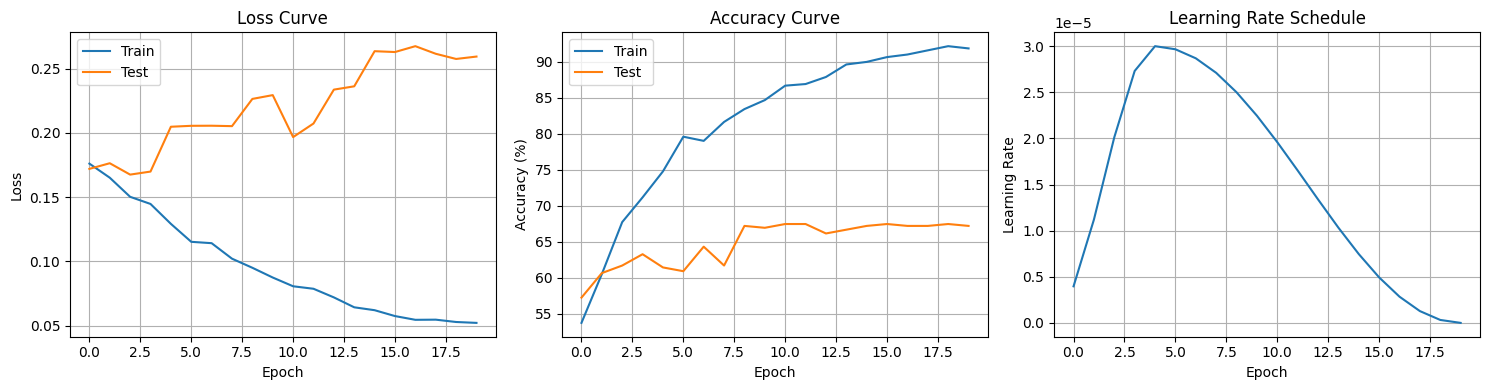


最佳测试准确率: 67.45%


In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["test_loss"], label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()
axes[0].grid(True)


axes[1].plot(history["train_acc"], label="Train")
axes[1].plot(history["test_acc"], label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Accuracy Curve")
axes[1].legend()
axes[1].grid(True)


axes[2].plot(history["lr"])
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_curves.png", dpi=150)
plt.show()

print(f"\n最佳测试准确率: {max(history['test_acc']):.2f}%")

In [17]:

best_checkpoint = torch.load(f"{OUTPUT_DIR}/best.pth", map_location=DEVICE)
model.load_state_dict(best_checkpoint["model_state_dict"])
print(f"加载最佳模型，来自 Epoch {best_checkpoint['epoch'] + 1}")


加载最佳模型，来自 Epoch 11


分类报告:
              precision    recall  f1-score   support

        Real       0.66      0.54      0.59       198
        Fake       0.58      0.70      0.64       183

    accuracy                           0.62       381
   macro avg       0.62      0.62      0.62       381
weighted avg       0.62      0.62      0.61       381



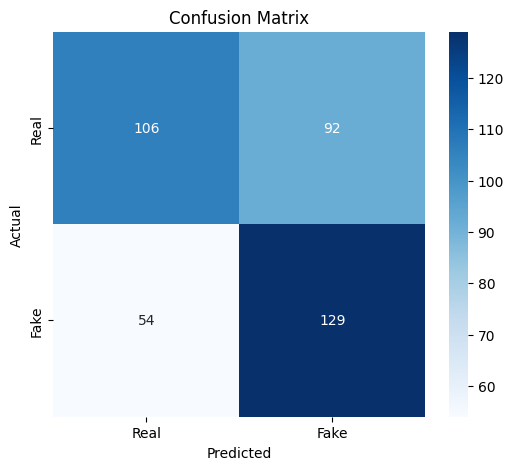

In [18]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos = videos.to(DEVICE)
        outputs = model(videos)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


print("分类报告:")
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=150)
plt.show()

In [19]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

overall_acc = (all_preds == all_labels).mean() * 100
print(f"\nVAL Overall Accuracy: {overall_acc:.2f}%  ({(all_preds==all_labels).sum()}/{len(all_labels)})")



VAL Overall Accuracy: 61.68%  (235/381)
